In [1]:
from snrei.utils.data import get_continents

continents = get_continents(name="geopandas-continents.zip")

/home/maxime/miniconda3/envs/venv/lib/python3.12/site-packages/pymssa/mssa.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


<Axes: >

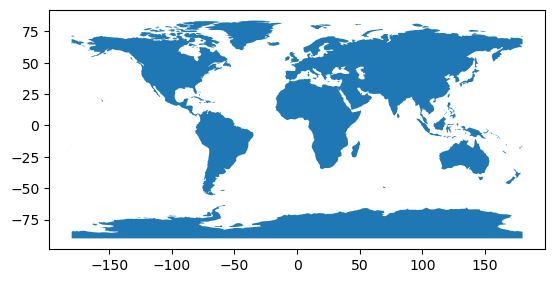

In [7]:
continents.plot()

# I - Build an Earth description
This class instance is built from 3 model files:
- elasticity model
- short term anelasticity model
- long term anelasticity model
and contains all preprocessed data necessary for Love number computations.

The user can modify these files or chose other files using the same formalism, whose names are given in class constructor parameters:

In [ ]:
from snrei import AnelasticityDescription

Earth_description = AnelasticityDescription(
    elasticity_name="PREM", short_term_anelasticity_name="uniform", long_term_anelasticity_name="uniform"
)

# II - Elastic Love numbers
The frequency independent Love numbers computation only uses the elasticity model of the previously defined instance.

The following function integrates the Earth model from the center of mass to the surface to give Love numbers for a given list of degrees.

This list of degrees is either given as a parameter or built from 2 parameter files. See the default value.

The following result is an array whose:
- axis in position 0 corresponds to degrees
- axis in position 1 corresponds to frequencies (only infinite for the elastic case)
- axis in position 2 corresponds to Love number type: h', l', k', h*, l*, k*, h, l, k

In [ ]:
from snrei import elastic_Love_numbers_computing, load_base_model, parameters_path, generate_degrees_list

degrees = generate_degrees_list(
    degree_thresholds=load_base_model(name="degree_thresholds", path=parameters_path),
    degree_steps=load_base_model(name="degree_steps", path=parameters_path),
)
elastic_Love_numbers = elastic_Love_numbers_computing(anelasticity_description=Earth_description, degrees=degrees)

In [ ]:
from matplotlib.pyplot import semilogx, figure, legend, grid, xlabel
from numpy import array

figure(figsize=(6, 2))
semilogx(degrees, -elastic_Love_numbers[:, 0, 0].real, label="$-h_n'$")
semilogx(degrees, array(object=degrees) * elastic_Love_numbers[:, 0, 1].real, label="$nl_n'$")
semilogx(degrees, -array(object=degrees) * elastic_Love_numbers[:, 0, 2].real, label="$-nk_n'$")
grid()
xlabel("$n$")
legend()

# III - Anlastic Love numbers
The following section uses the previously defined Earth description to compute frequency dependent Love numbers.

It uses multiple processes on available cores.

See the class LoveNumbersHyperParameters to understand all underlying parameters.

The following result is an array whose:
- axis in position 0 corresponds to degrees
- axis in position 1 corresponds to frequencies
- axis in position 2 corresponds to Love number type: h', l', k', h*, l*, k*, h, l, k

In [ ]:
from snrei import (
    load_Love_numbers_hyper_parameters,
    get_run_folder_name,
    results_path,
    generate_log_frequency_initial_values,
)

Love_numbers_hyper_parameters = load_Love_numbers_hyper_parameters()

log_frequency_initial_values = generate_log_frequency_initial_values(
    frequency_min=Love_numbers_hyper_parameters.frequency_min,
    frequency_max=Love_numbers_hyper_parameters.frequency_max,
    n_frequency_0=Love_numbers_hyper_parameters.n_frequency_0,
    frequency_unit=Earth_description.frequency_unit,
)

run_id = Love_numbers_hyper_parameters.run_hyper_parameters.run_id()
result_subpath = results_path.joinpath(get_run_folder_name(anelasticity_description_id=Earth_description.id, run_id=run_id))

In [ ]:
from snrei import anelastic_Love_numbers_computing

log_frequencies, anelastic_Love_numbers = anelastic_Love_numbers_computing(
    max_tol=Love_numbers_hyper_parameters.max_tol,
    decimals=Love_numbers_hyper_parameters.decimals,
    y_system_hyper_parameters=Love_numbers_hyper_parameters.y_system_hyper_parameters,
    use_long_term_anelasticity=Love_numbers_hyper_parameters.run_hyper_parameters.use_long_term_anelasticity,
    use_short_term_anelasticity=Love_numbers_hyper_parameters.run_hyper_parameters.use_short_term_anelasticity,
    use_bounded_attenuation_functions=Love_numbers_hyper_parameters.run_hyper_parameters.use_bounded_attenuation_functions,
    degrees=degrees,
    log_frequency_initial_values=log_frequency_initial_values,
    anelasticity_description=Earth_description,
    result_subpath=result_subpath,
    save_result_per_degree=Love_numbers_hyper_parameters.save_result_per_degree,
)

In [ ]:
from snrei import frequencies_to_periods

figure(figsize=(8, 2))
semilogx(
    frequencies_to_periods(frequencies=Earth_description.frequency_unit * 10.0**log_frequencies),
    -anelastic_Love_numbers[2, :, 0].real,
    label="$-h_{2, real}'$",
)
grid()
xlabel("$T$ (yr)")
legend()

# IV - The Result class file
The following function performs a frequency dependent Love numbers computation, but directly from model file names and it also saves the results as a Result instance in a (.JSON) file.

Below is an example on how to load such a result file.

In [ ]:
from snrei import Love_numbers_single_run

description_id = Love_numbers_single_run(
    elasticity_model_name="PREM",
    short_term_anelasticity_model_name="uniform",
    long_term_anelasticity_model_name="uniform",
    run_hyper_parameters=Love_numbers_hyper_parameters.run_hyper_parameters,
    Love_numbers_hyper_parameters=Love_numbers_hyper_parameters,
)

In [ ]:
from snrei import Result, Direction, BoundaryCondition

Love_numbers = Result()
Love_numbers.load(name="anelastic_Love_numbers", path=result_subpath)
sum(sum(Love_numbers.values[Direction.radial][BoundaryCondition.load] - anelastic_Love_numbers[:, :, 0]))

# V - Loop on Earth Descriptions options
This section performs a *Love_numbers_single_run* for a given panel of model names, run otions and eventually variable parameters.

In [ ]:
from snrei import Love_numbers_for_options_for_models_for_parameters, ModelPart

anelasticity_description_ids = Love_numbers_for_options_for_models_for_parameters(
    elasticity_model_names=["PREM"],
    long_term_anelasticity_model_names=["VM7"],
    short_term_anelasticity_model_names=[
        "Benjamin_Q_Resovsky",
    ],
    parameters={ModelPart.long_term_anelasticity: {"eta_m": {"D''": [[1e17]]}}},
)